# Data Transformation by Discretization

> Hands‑on demo to accompany the slide **‘Data Transformation by Discretization’**. This notebook shows how to convert continuous features into bins and how that affects models.

**What you will learn**
- What discretization (binning) is and when to use it
- Unsupervised methods: equal‑width, equal‑frequency (quantile), and k‑means binning
- Supervised binning idea using a shallow decision tree to find cut points
- How to use `pandas.cut`, `pandas.qcut`, and `sklearn.KBinsDiscretizer`
- How binning interacts with linear models vs. tree‑based models
- Good practices: pipelines, handling unseen values, choosing K, edge cases


## 0. Setup (packages)
Run this once in VS Code to install dependencies.

In [ ]:
#%pip -q install numpy pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Imports & reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

np.random.seed(42)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (10,4)

## 2. Concept — What is discretization?
**Discretization** (a.k.a. *binning*) turns a continuous feature (e.g., age, income) into a small number of intervals (bins), like `young/middle/senior`.

**Why do this?**
- Make models/plots easier to interpret.
- Feed algorithms that expect categories.
- Capture non‑linear, step‑like relationships with simple linear models.

**Caveats:** If bins are too few you lose detail; too many and you add noise. Always validate with a train/test split.

## 3. Create a toy dataset
We’ll simulate customers with features `age`, `income`, `visits_per_month`, and a binary target `spend_high`. The target will depend on age in a step‑like way so binning is useful.

In [3]:
n = 600
age = np.random.uniform(18, 70, size=n)
income = np.random.normal(65000, 12000, size=n)
visits = np.clip(np.random.normal(5, 2, size=n), 0, None)
# Step-like probability by age bands (hidden rule)
p = np.where(age < 25, 0.25, np.where(age < 40, 0.45, np.where(age < 55, 0.60, 0.35)))
p = np.clip(p + 0.002*(visits-5) + 0.000004*(income-65000), 0.05, 0.95)
spend_high = (np.random.rand(n) < p).astype(int)
df = pd.DataFrame({'age':age, 'income':income.astype(int), 'visits_per_month':visits, 'spend_high':spend_high})
df.head()

,age,income,visits_per_month,spend_high
0,37.476086,58636,3.899390,1
1,67.437144,55485,3.656753,0
2,56.063685,63715,4.948892,0
3,49.130241,52577,7.345458,1
4,26.112969,58356,6.087200,0


### Distributions (before binning)

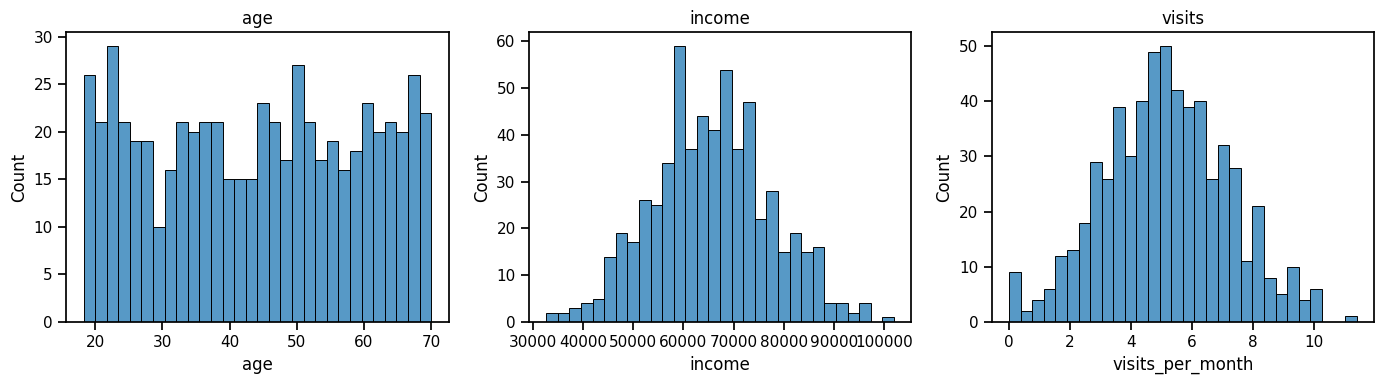

In [4]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.histplot(df['age'], bins=30, ax=axes[0]); axes[0].set_title('age')
sns.histplot(df['income'], bins=30, ax=axes[1]); axes[1].set_title('income')
sns.histplot(df['visits_per_month'], bins=30, ax=axes[2]); axes[2].set_title('visits')
plt.tight_layout(); plt.show()

## 4. Unsupervised discretization with `pandas`
We’ll discretize `age` into 4 bins using **equal‑width** and **equal‑frequency (quantile)** rules.

In [5]:
df['age_bin_width'] = pd.cut(df['age'], bins=4)
df['age_bin_quant'] = pd.qcut(df['age'], q=4)
df[['age','age_bin_width','age_bin_quant']].head()

,age,age_bin_width,age_bin_quant
0,37.476086,"(31.194, 44.124]","(30.584, 44.9]"
1,67.437144,"(57.055, 69.985]","(57.7, 69.985]"
2,56.063685,"(44.124, 57.055]","(44.9, 57.7]"
3,49.130241,"(44.124, 57.055]","(44.9, 57.7]"
4,26.112969,"(18.211, 31.194]","(18.262, 30.584]"


### Compare counts per bin

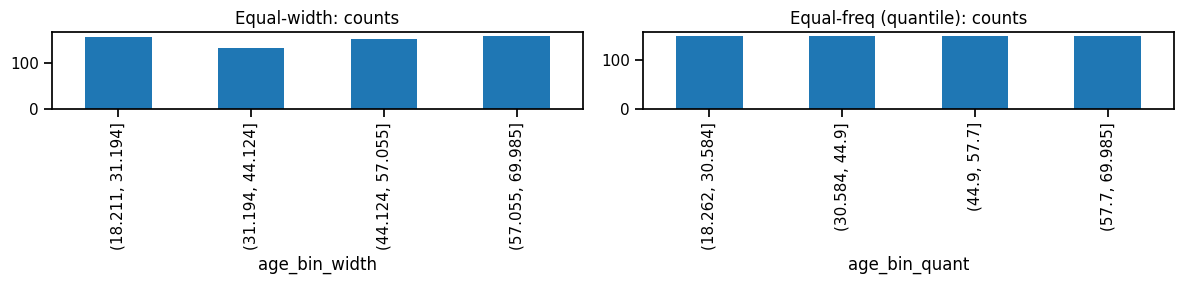

In [6]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
df['age_bin_width'].value_counts().sort_index().plot(kind='bar', ax=axes[0], title='Equal‑width: counts')
df['age_bin_quant'].value_counts().sort_index().plot(kind='bar', ax=axes[1], title='Equal‑freq (quantile): counts')
plt.tight_layout(); plt.show()

## 5. Discretization with scikit‑learn `KBinsDiscretizer`
`KBinsDiscretizer` supports strategies: `'uniform'` (equal‑width), `'quantile'` (equal‑frequency), and `'kmeans'` (cluster‑based). We’ll create 4 bins for `age` and use **one‑hot** encoding of the bins to feed a linear model.

In [7]:
X = df[['age']].copy()
y = df['spend_high']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

disc = KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile')
lr = LogisticRegression(max_iter=500)
pipe = Pipeline([('disc', disc), ('lr', lr)])
pipe.fit(X_train, y_train)
score_disc = pipe.score(X_test, y_test)
# Baseline: same linear model but on raw age (no binning)
lr_raw = LogisticRegression(max_iter=500).fit(X_train, y_train)
score_raw = lr_raw.score(X_test, y_test)
score_raw, score_disc

c:\StudentWork\Code\PROG8245\DataTransformationDemos\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


(0.6066666666666667, 0.5933333333333334)

**Interpretation:** With a step‑like target, the binned version can help a linear model by capturing thresholds; the exact numbers will vary but you should see binning hold its own or improve slightly.

## 6. Supervised idea: let a shallow tree suggest cut points
A small decision tree can find splits (thresholds) that best separate the target. We can use those thresholds as bin edges.

In [8]:
tree = DecisionTreeClassifier(max_depth=2, random_state=42)
tree.fit(X_train, y_train)
thresholds = sorted(set(tree.tree_.threshold[tree.tree_.threshold > -2]))
thresholds


[np.float64(23.666526794433594),
 np.float64(25.12120246887207),
 np.float64(54.21049499511719)]

### Build bins from tree thresholds and compare

In [9]:
edges = [-np.inf] + thresholds + [np.inf]
age_train_bins = pd.cut(X_train['age'], bins=edges)
age_test_bins = pd.cut(X_test['age'], bins=edges)
# One-hot the bins manually
Xtr_binned = pd.get_dummies(age_train_bins, prefix='age_bin', drop_first=False)
Xte_binned = pd.get_dummies(age_test_bins, prefix='age_bin', drop_first=False)
lr2 = LogisticRegression(max_iter=500).fit(Xtr_binned, y_train)
score_treebins = lr2.score(Xte_binned, y_test)
score_raw, score_disc, score_treebins


(0.6066666666666667, 0.5933333333333334, 0.6066666666666667)

## 7. Multiple features + Pipeline
Use `ColumnTransformer` to discretize selected columns and pass others through.

In [10]:
X_all = df[['age','income','visits_per_month']]
y = df['spend_high']
X_tr, X_te, y_tr, y_te = train_test_split(X_all, y, test_size=0.25, random_state=42)
prep = ColumnTransformer([
    ('age_bins', KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile'), ['age']),
    ('visits_bins', KBinsDiscretizer(n_bins=3, encode='onehot-dense', strategy='uniform'), ['visits_per_month'])
], remainder='passthrough')
model = Pipeline([('prep', prep), ('clf', LogisticRegression(max_iter=500))])
model.fit(X_tr, y_tr)
model.score(X_te, y_te)


c:\StudentWork\Code\PROG8245\DataTransformationDemos\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


0.6133333333333333

## 8. Edge cases & tips
- **How many bins?** Start with 3–5. Too many bins can overfit.
- **Unseen values:** `KBinsDiscretizer` stores edges learned on train and applies them to test—good!
- **Missing values:** impute before binning (not shown here).
- **Tree models:** Tree‑based models already split features; binning is usually unnecessary for them.
- **Ordinal vs one‑hot of bins:** For linear models, one‑hot of bins is often better than ordinal integers.

## 9. Practice exercises
1. Change `n_bins` to 3, 5, and 8 in the `KBinsDiscretizer` and compare accuracy.
2. Swap strategies (`'uniform'`, `'quantile'`, `'kmeans'`) and observe differences in bin edges.
3. Try discretizing `income` and see if it helps the model.
4. Add Gaussian noise to `age` and check how robust your binning is.
5. Build a tiny function that wraps `pd.cut` and returns one‑hot columns for any numeric Series.

---
_Last updated: 2026-02-14 16:51:12 UTC_
